In [1]:
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
img_label_file = "data/labels.csv"

labels_csv = pd.read_csv(img_label_file, index_col=0)
labels = labels_csv.loc["fall-01"]
label_1 = labels.loc[labels["frame"] == 1]
label_1.label

fall name
fall-01   -1
Name: label, dtype: int64

In [3]:
### Read in the data
img_data_dir = "data/images/"
img_label_file = "data/labels.csv"

## Given an image name, extracts the label from the labels.csv file. True if 1 False if -1
def extract_label(file_name):
    split = file_name.split("-") # split image name
    fall_name = split[0] + "-" + split[1] # reconstruct fall name
    frame = int(split[-1].split(".")[0]) # end of split is like 113.png. removes .png part
    fall_labels = labels_csv.loc[fall_name]
    frame_label = fall_labels.loc[fall_labels["frame"] == frame]
    return int(frame_label.label) > 0

### Loads in the data from images and stores it in an array. Order is important because 
### the labels are in the same order as the images are appended to the array
def load_img_data():
    imgs = []
    labels = []
    labels_csv = pd.read_csv(img_label_file)
    
    # Iterates through fall folders and the frames within each fall
    for img_folder in os.listdir(img_data_dir):
        path = os.path.join(img_data_dir,img_folder)
        if ("fall" in path and "zip" not in path):
            for file in os.listdir(path):
                img = cv2.imread(os.path.join(path, file))
                img = cv2.resize(img ,(224,224))
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                imgs.append(img)
                labels.append([extract_label(file)])
                
    return imgs, labels

In [4]:
images, labels = load_img_data()

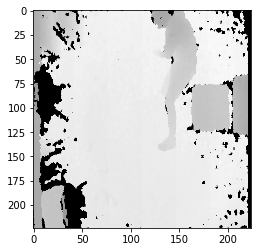

In [5]:
# View image to check if the data was read in and processed correctly

import matplotlib.pyplot as plt
plt.imshow(images[0])

In [6]:
# Split data into train and test sets

from sklearn.model_selection import train_test_split
images = np.asarray(images)
labels = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33)

In [30]:
# Transfer learning modifications to the model

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

# Get VGG16 model architecture pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output

# Add other layers
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
    if i < 0: # We changed this number to change the number of blocks frozen
        layer.trainable = False

0 input_4
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [31]:
# Compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10)

Train on 4013 samples
Epoch 1/10
4013/4013 [==============================] - 106s 26ms/sample - loss: 2.6814 - accuracy: 0.6810
Epoch 2/10
4013/4013 [==============================] - 103s 26ms/sample - loss: 0.6192 - accuracy: 0.6935
Epoch 3/10
4013/4013 [==============================] - 103s 26ms/sample - loss: 0.6189 - accuracy: 0.6935
Epoch 4/10
4013/4013 [==============================] - 103s 26ms/sample - loss: 0.6238 - accuracy: 0.6895
Epoch 5/10
4013/4013 [==============================] - 102s 26ms/sample - loss: 0.6171 - accuracy: 0.6935
Epoch 6/10
4013/4013 [==============================] - 102s 25ms/sample - loss: 0.6191 - accuracy: 0.6935
Epoch 7/10
4013/4013 [==============================] - 102s 25ms/sample - loss: 0.6169 - accuracy: 0.6935
Epoch 8/10
4013/4013 [==============================] - 102s 25ms/sample - loss: 0.6168 - accuracy: 0.6935
Epoch 9/10
4013/4013 [==============================] - 102s 25ms/sample - loss: 0.6167 - accuracy: 0.6935
Epoch 10/10
401

In [26]:
# Evaluate model on our test set
model.evaluate(X_test, y_test)

1977/1977 [==============================] - 17s 9ms/sample - loss: 0.6043 - accuracy: 0.7086


[0.604298121138058, 0.70864946]

In [27]:
# Get predictions to calculate precision, recall, F1 score
y_pred = model.predict(X_test)

In [28]:
np.save("y_pred_transfer_learning_no_data_aug", y_pred)
np.save("y_test_transfer_learning_no_data_aug", y_test)

In [29]:
# Calculate precision, recall, F1 score. In the table, false - not a fall; true - a fall
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

       False       0.71      1.00      0.83      1401
        True       0.00      0.00      0.00       576

    accuracy                           0.71      1977
   macro avg       0.35      0.50      0.41      1977
weighted avg       0.50      0.71      0.59      1977



/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Create confusion matrix

y_test_matrix = []
for i in y_test:
    y_test_matrix.append(i[0])
    
y_pred_matrix = []
y_pred_bool = y_pred > 0.5
for i in y_pred_bool:
    y_pred_matrix.append(i[0])

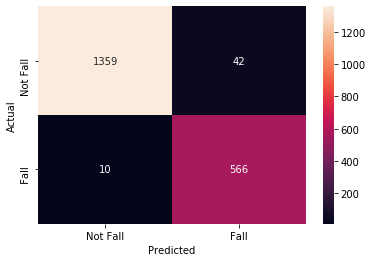

In [14]:
import matplotlib.pyplot as plt

import seaborn as sn
data = {'y_Actual':   y_test_matrix,
        'y_Predicted': y_pred_matrix
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])


sn.heatmap(confusion_matrix,xticklabels=['Not Fall', 'Fall'], yticklabels=[ 'Not Fall', ' Fall'],fmt='g', annot=True)
plt.show()

In [15]:
# Running our own Kinect images on the model, which are located in the "samples" directory.

sample_data_dir = "samples"

def load_sample_data():
    imgs = []
    labels = []
    
    # Iterates through fall folders and the frames within each fall
    for img in os.listdir(sample_data_dir):
        file = os.path.join(sample_data_dir,img)
        print(file)
        if ("png" not in file):
            continue
        img = cv2.imread(file)
        img = cv2.resize(img ,(224,224))
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        imgs.append(img)
        if ("fall" in file):
            labels.append(1)
        else:
            labels.append(0)           
                
    return imgs, labels

In [16]:
imgs, labels = load_sample_data()
imgs = np.asarray(imgs)
labels = np.asarray(labels)
predictions = model.predict(imgs)
pred = predictions > 0.5

samples/fall4.png
samples/standing3.png
samples/fall.png
samples/fall3.png
samples/fall6.png
samples/standing1.png
samples/fall2.png
samples/fall5.png
samples/fall1.png
samples/standing2.png


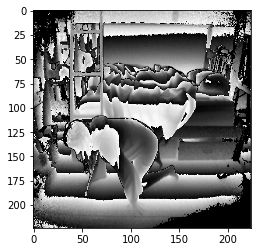

Image is classified by the model as:[False]


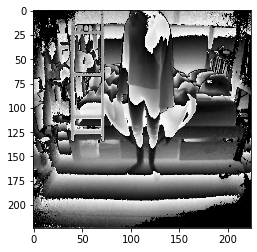

Image is classified by the model as:[False]


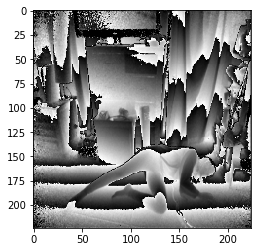

Image is classified by the model as:[False]


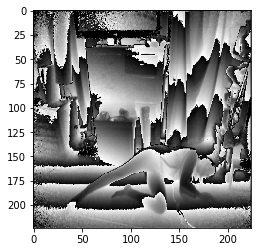

Image is classified by the model as:[ True]


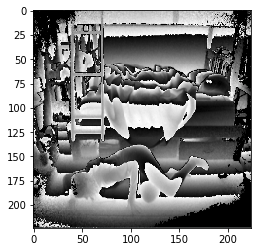

Image is classified by the model as:[False]


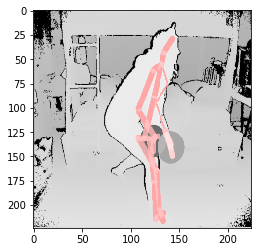

Image is classified by the model as:[False]


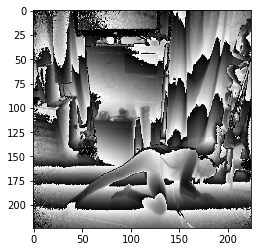

Image is classified by the model as:[ True]


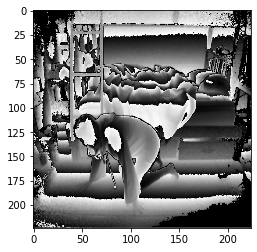

Image is classified by the model as:[False]


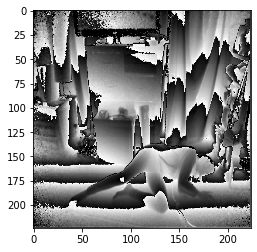

Image is classified by the model as:[False]


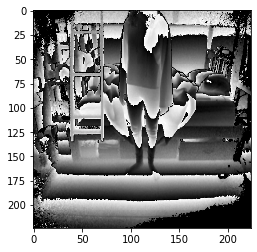

Image is classified by the model as:[False]


In [17]:
# Looking at the Kinect images and seeing what our model classified them as

import matplotlib.pyplot as plt

for i, img in enumerate(imgs):
    plt.imshow(img)
    plt.show()
    print("Image is classified by the model as:" + str(pred[i]))